In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from src.data_loader import RotatedImagesDataset
from src.network import CNNNetwork

In [95]:
# Load dataset.
ground_truth = pd.read_csv("dataset/ground-truth.csv")

rotated_dataset = RotatedImagesDataset("dataset/images", ground_truth)

### Visualize raw dataset

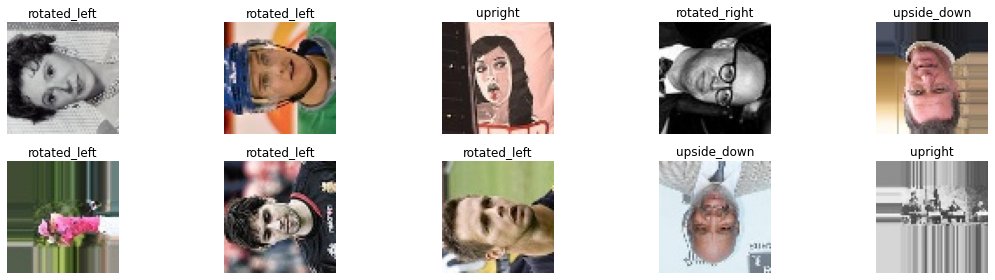

In [96]:
images_to_show = rotated_dataset[0:10]

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 4))
for i, (image, label) in enumerate(images_to_show):
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(rotated_dataset.index_to_label[label])
    ax.ravel()[i].set_axis_off()
plt.tight_layout()
plt.show()

### Visualize augmented dataset

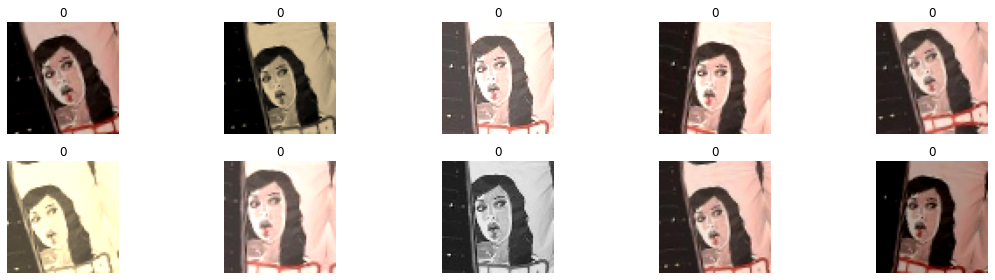

In [97]:
dataset_transform = A.Compose(
    [
        A.ShiftScaleRotate(p=0.6, shift_limit=0.1, rotate_limit=15),
        A.RandomBrightnessContrast(p=0.7),
        A.ToGray(p=0.3),
        A.ToSepia(p=0.2),
    ]
)
rotated_dataset_loader = RotatedImagesDataset("dataset/images", ground_truth, transform=dataset_transform)

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 4))
image_augmented_samples = 10
for i in range(image_augmented_samples):
    image = rotated_dataset_loader[2]
    ax.ravel()[i].imshow(image[0])
    ax.ravel()[i].set_title(image[1])
    ax.ravel()[i].set_axis_off()
plt.tight_layout()
plt.show()

### Load and test model

In [98]:
# Load trained parameters.
model_trained = CNNNetwork()
state_dict = torch.load("saved_model/trained_model.pt")
model_trained.load_state_dict(state_dict)
model_trained.eval()

CNNNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)

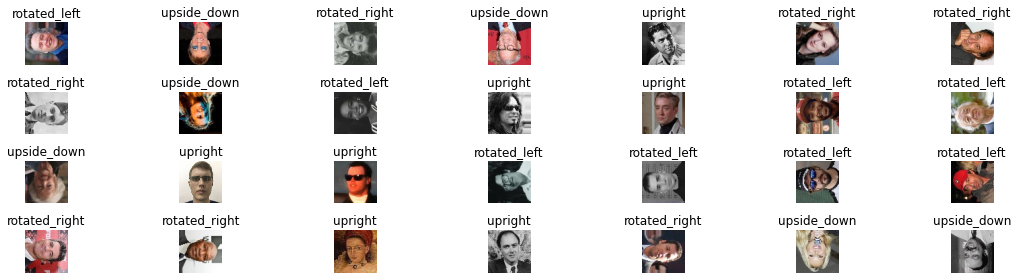

In [104]:
test_images_path = "dataset/test"
test_dataset_transform = A.Compose([A.Resize(64, 64), ToTensorV2()])

figure, ax = plt.subplots(nrows=4, ncols=7, figsize=(16, 4))
for i, file in enumerate(os.listdir(test_images_path)):
    image_path = os.path.join(test_images_path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = test_dataset_transform(image=image)["image"]
    output = model_trained(image_tensor.unsqueeze(0).float())
    _, predicted = torch.max(output, 1)
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(rotated_dataset.index_to_label[predicted.item()])
    ax.ravel()[i].set_axis_off()
plt.tight_layout()
plt.show()